In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load dataset
df = pd.read_csv("network_data_cleaned.csv")

# Drop missing labels
df = df.dropna(subset=["label"])

# Drop leakage features
leak_features = ["dst_port", "ip_byte_ratio", "src_ip_bytes", "conn_state", "duration"]
X = df.drop(columns=leak_features + ["label"])
y = df["label"].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to benchmark
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

# Evaluate all models
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train_scaled, y_train)

    calibrated = CalibratedClassifierCV(model, method="isotonic", cv=5)
    calibrated.fit(X_train_scaled, y_train)

    y_pred = calibrated.predict(X_test_scaled)
    y_prob = calibrated.predict_proba(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    try:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
    except:
        roc_auc = "N/A"

    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))



Random Forest
Accuracy: 0.9714854338949319
F1 Score: 0.9715455830257639
ROC AUC: 0.995990161929328
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      4960
           1       0.99      0.97      0.98      4752
           2       0.99      0.99      0.99      4137
           3       0.96      0.98      0.97      5002
           4       0.94      0.96      0.95      5466
           5       0.97      0.96      0.97      4826

    accuracy                           0.97     29143
   macro avg       0.97      0.97      0.97     29143
weighted avg       0.97      0.97      0.97     29143


Gradient Boosting
Accuracy: 0.9623923412140136
F1 Score: 0.9624370872937328
ROC AUC: 0.9952242112453971
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      4960
           1       0.99      0.96      0.97      4752
           2       0.99      0.98      0.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lime
import lime.lime_tabular

# Load dataset
df = pd.read_csv("network_data_cleaned.csv")
df = df.dropna(subset=["label"])

# Drop leakage features
leak_features = ["dst_port", "ip_byte_ratio", "src_ip_bytes", "conn_state", "duration"]
X = df.drop(columns=leak_features + ["label"])
y = df["label"].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base models
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# --- Hybrid Models --- #
# 2-model: XGB + LGBM
hybrid_2 = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('lgbm', lgbm)
], voting='soft')

# 3-model: XGB + LGBM + RF
hybrid_3 = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('rf', rf)
], voting='soft')

# 4-model: XGB + LGBM + RF + GB
hybrid_4 = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('rf', rf),
    ('gb', gb)
], voting='soft')

# --- Fit and Evaluate Hybrid Models --- #
def evaluate_model(name, model):
    print(f"\nEvaluating {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")

    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return model

# Best base model
xgb_model = evaluate_model("XGBoost (Base Model)", xgb)

# Hybrids
hybrid_2_model = evaluate_model("Hybrid 2: XGB + LGBM", hybrid_2)
hybrid_3_model = evaluate_model("Hybrid 3: XGB + LGBM + RF", hybrid_3)
hybrid_4_model = evaluate_model("Hybrid 4: XGB + LGBM + RF + GB", hybrid_4)


Evaluating XGBoost (Base Model)
Accuracy: 0.9709021034210616
F1 Score: 0.9710117822578916
ROC AUC: 0.9983012474627454
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      4960
           1       0.99      0.97      0.98      4752
           2       0.99      0.99      0.99      4137
           3       0.96      0.97      0.97      5002
           4       0.93      0.97      0.95      5466
           5       0.97      0.96      0.97      4826

    accuracy                           0.97     29143
   macro avg       0.97      0.97      0.97     29143
weighted avg       0.97      0.97      0.97     29143


Evaluating Hybrid 2: XGB + LGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Num


 LIME Explanations for XGBoost (Base Model)

 Instance 1


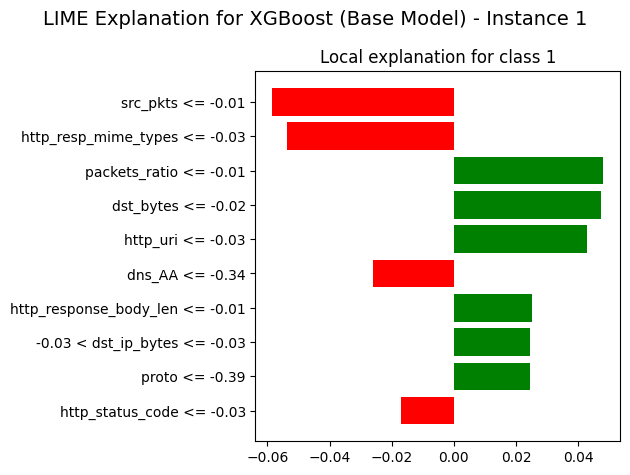


 Instance 2


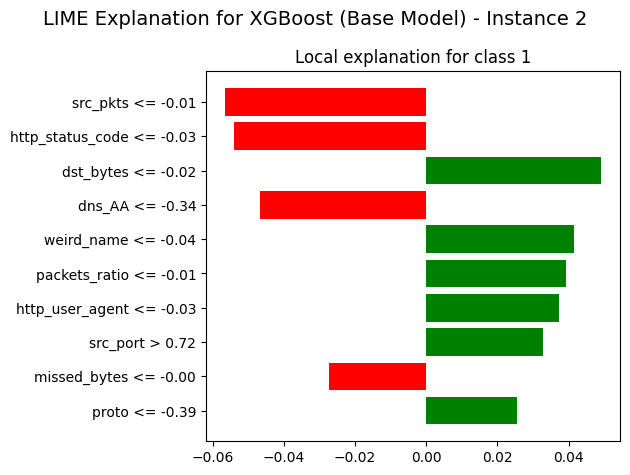


 Instance 3


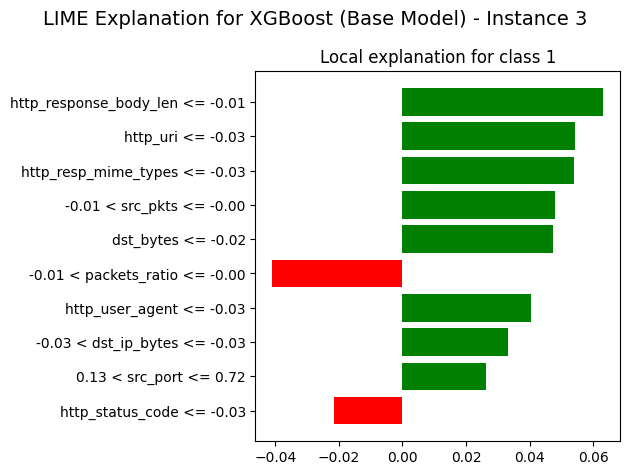


 LIME Explanations for Hybrid 2: XGB + LGBM

 Instance 1


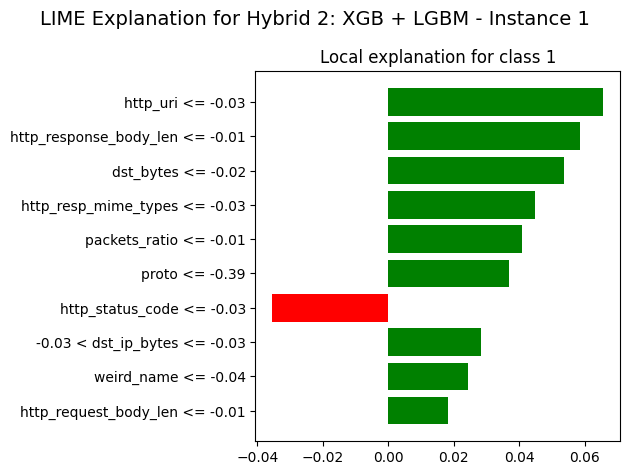


 Instance 2


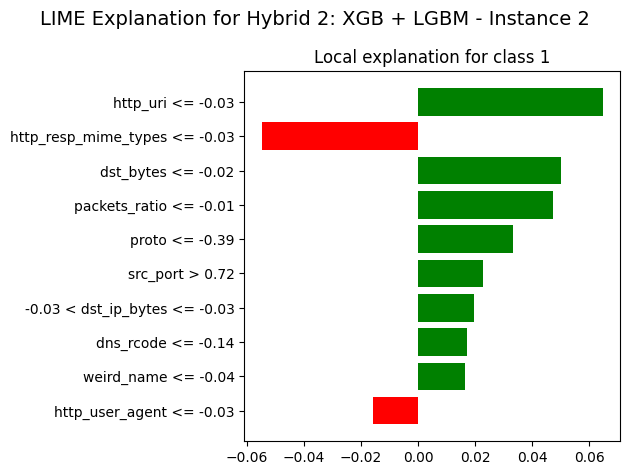


 Instance 3


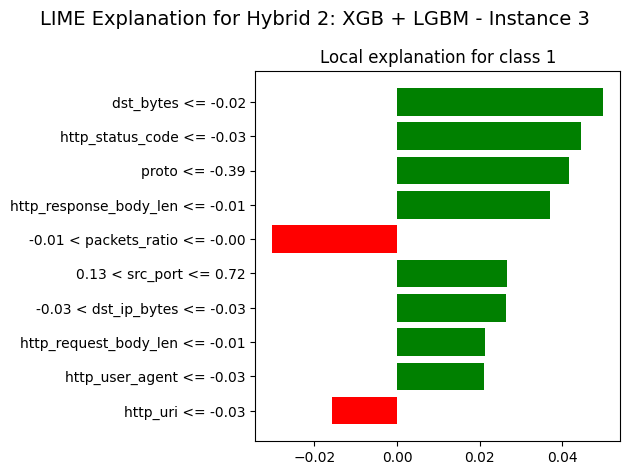


 LIME Explanations for Hybrid 3: XGB + LGBM + RF

 Instance 1


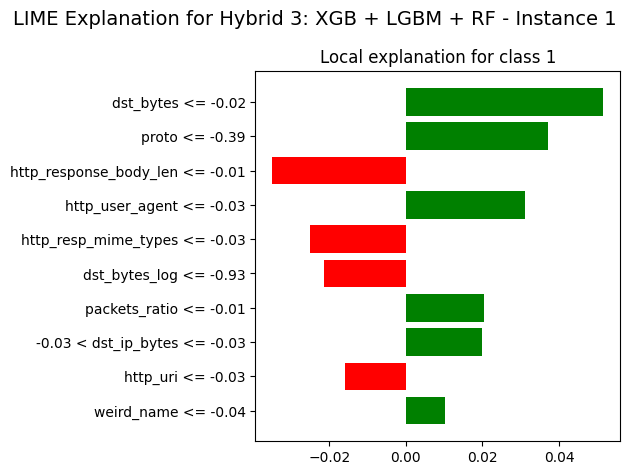


 Instance 2


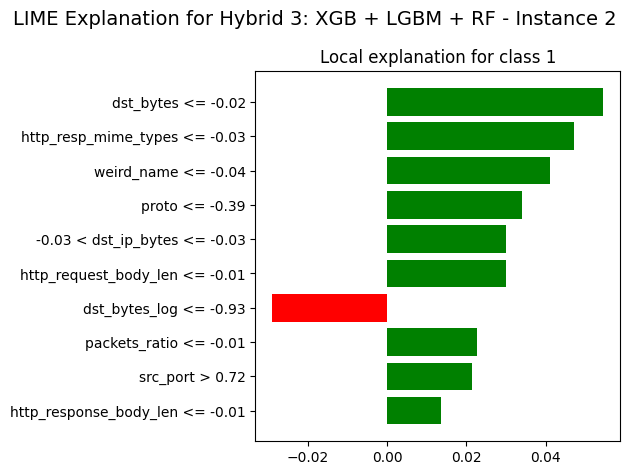


 Instance 3


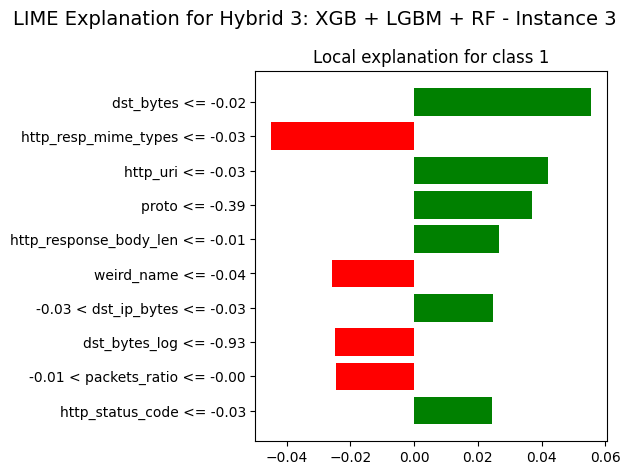


 LIME Explanations for Hybrid 4: XGB + LGBM + RF + GB

 Instance 1


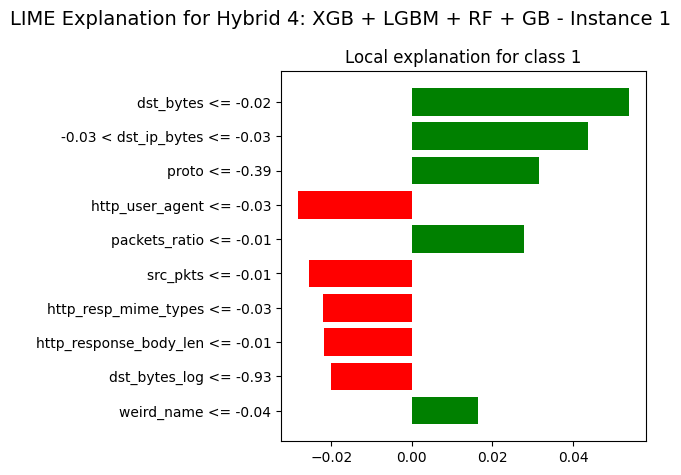


 Instance 2


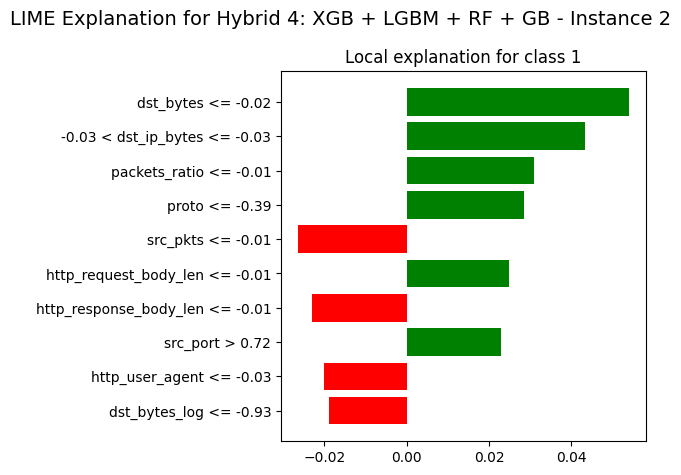


 Instance 3


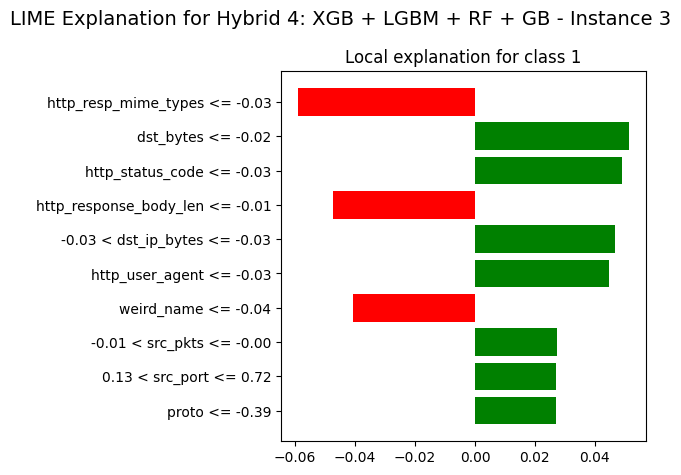

In [4]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Random Test Samples

np.random.seed(42)
sample_indices = np.random.choice(range(X_test_scaled.shape[0]), size=3, replace=False)
sample_instances = X_test_scaled[sample_indices]


# LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in np.unique(y)],
    mode="classification"
)


# predict_proba Compatibility

def safe_predict_proba(model):
    def wrapper(X):
        try:
            return model.predict_proba(X)
        except AttributeError:
            # One-hot encode predictions
            preds = model.predict(X)
            n_classes = len(np.unique(y))
            return np.eye(n_classes)[preds]
    return wrapper


# Matplotlib

def explain_with_lime(model, model_name):
    print(f"\n LIME Explanations for {model_name}")
    for i, instance in enumerate(sample_instances):
        print(f"\n Instance {i+1}")
        exp = explainer.explain_instance(
            data_row=instance,
            predict_fn=safe_predict_proba(model),
            num_features=10
        )

        fig = exp.as_pyplot_figure()
        fig.suptitle(f'LIME Explanation for {model_name} - Instance {i+1}', fontsize=14)
        plt.tight_layout()
        plt.show()


# 5. Call Explanation 

explain_with_lime(xgb_model, "XGBoost (Base Model)")
explain_with_lime(hybrid_2_model, "Hybrid 2: XGB + LGBM")
explain_with_lime(hybrid_3_model, "Hybrid 3: XGB + LGBM + RF")
explain_with_lime(hybrid_4_model, "Hybrid 4: XGB + LGBM + RF + GB")
